##Initial Setup



*   Mount google drive
*   install dependencies
*   Import libraries
*   Configure pyspark
*   Unzip data into colab disk memory(faster than unzipping in drive)








In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install elephas
!pip install pyngrok==4.1.1
# !pip install pyspark
!apt install openjdk-8-jdk-headless --yes


In [3]:
#imports
import io
import os
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np
import matplotlib.pyplot as plt
from pyngrok import ngrok
from zipfile import ZipFile
#pyspark
import pyspark
from pyspark.sql.functions import col, pandas_udf, PandasUDFType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.types import StructType,StructField,ArrayType,StringType,LongType,BinaryType,IntegerType,FloatType,DoubleType
from pyspark import SparkContext, SparkConf
# Elephas for Deep Learning on Spark
from elephas.ml_model import ElephasEstimator, ElephasTransformer,load_ml_transformer
from elephas.utils.model_utils import ModelType, argmax
#Keras Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array
from keras .models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers

plt.rcParams["figure.figsize"] = (8,5.5)


In [4]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050").set('spark.driver.memory', '100G').set('spark.driver.maxResultSize', '100G')
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "32")

In [6]:
!killall ngrok
!ngrok authtoken {'296gloYMZx0IEn84mbVMCKzo1SV_6Sp5sYcPoFygBrSxhqrgs'}
public_url = ngrok.connect(port='4050')
print("Pyspark UI URL : ",public_url)
## use to kill ngrock sessions
# !killall ngrok

ngrok: no process found
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
Pyspark UI URL :  http://8a82-35-197-49-33.ngrok.io


In [7]:
with ZipFile('/content/drive/MyDrive/Big_data_data/plant_data_v1.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall('unzip_plant')
   print('File is unzipped in temp folder') 

File is unzipped in temp folder


##Data Preprocessing


*   Remove some data to escape memory issues: After removing data ,each class can have at max 1800 images.
*   Further only select classes of plants that have atleast two sub categories(e.h healthy apple , apple scab).This leaves us with 33 classes from 9 different plants
*   Get labels names from the folder names and encode them in dictionary.
*   Import all data after resizing the into pyspark dataframe and label it.
*   resize size of images and flatten them into a list.
*   Convert the array into Dense Vector type for pyspark compatibility.



In [9]:
rootdir = '/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train'
for it in os.scandir(rootdir):
  if it.is_dir():
    count = 0
    dir_path = it.path
    for path in os.scandir(dir_path):
        if path.is_file():
            count += 1
            if count>1800:
              os.remove(path)
    print(it.path)

/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Strawberry___Leaf_scorch
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Pepper,_bell___Bacterial_spot
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Raspberry___healthy
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Peach___healthy
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Tomato___Early_blight
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Apple___Cedar_apple_rust
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Orange___Haunglongbing_(Citrus_greening)
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/

In [10]:
for it in os.scandir(rootdir):
  if it.is_dir():
    count = 0
    dir_path = it.path
    for path in os.scandir(dir_path):
        if path.is_file():
            count += 1
    print(it.path)
    print('file count:', count)

/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
file count: 1722
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Strawberry___Leaf_scorch
file count: 1774
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Pepper,_bell___Bacterial_spot
file count: 1800
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Raspberry___healthy
file count: 1781
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Peach___healthy
file count: 1728
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Tomato___Early_blight
file count: 1800
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot
file count: 1800
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Apple___Cedar_apple_rust
file count: 1760
/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train/Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
file count: 1642
/content/unz

In [11]:
selected_plants=['Apple','Cherry','Corn','Grape','Peach','Pepper','Potato','Strawberry','Tomato']
rootdir = '/content/unzip_plant/New Plant Diseases Dataset(Augmented)/train'
rootdir_test='/content/unzip_plant/New Plant Diseases Dataset(Augmented)/valid'
get_label={}
i=0
for it in os.scandir(rootdir):
    class_plant=os.path.basename(os.path.normpath(it.path))
    if it.is_dir() and class_plant.startswith(tuple(selected_plants)):
      get_label[class_plant]=i
      i=i+1

In [12]:
get_label

{'Apple___Apple_scab': 17,
 'Apple___Black_rot': 5,
 'Apple___Cedar_apple_rust': 6,
 'Apple___healthy': 31,
 'Cherry_(including_sour)___Powdery_mildew': 15,
 'Cherry_(including_sour)___healthy': 29,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 12,
 'Corn_(maize)___Northern_Leaf_Blight': 13,
 'Corn_(maize)___healthy': 30,
 'Grape___Black_rot': 16,
 'Grape___Esca_(Black_Measles)': 11,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 0,
 'Grape___healthy': 22,
 'Peach___Bacterial_spot': 28,
 'Peach___healthy': 3,
 'Pepper,_bell___Bacterial_spot': 2,
 'Pepper,_bell___healthy': 24,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 27,
 'Potato___healthy': 9,
 'Strawberry___Leaf_scorch': 1,
 'Strawberry___healthy': 32,
 'Tomato___Bacterial_spot': 8,
 'Tomato___Early_blight': 4,
 'Tomato___Late_blight': 10,
 'Tomato___Leaf_Mold': 23,
 'Tomato___Septoria_leaf_spot': 25,
 'Tomato___Spider_mites Two-spotted_spider_mite': 26,
 'Tomato___Target_Spot'

In [ ]:
#Save the encoded label dictionay
import pickle
a_file = open("inal_label_to_disease_2_june_v4", "wb")
pickle.dump(get_label, a_file)
a_file.close()

In [14]:
image_h=24
image_w=24
channels=3
#create empty datframe
emptyRDD = spark.sparkContext.emptyRDD()
schema =StructType([
        StructField('content',BinaryType(),True),
        StructField('label',IntegerType(),True)
    ])
images_df = spark.createDataFrame(emptyRDD,schema)

#import data
for it in os.scandir(rootdir):
    class_plant=os.path.basename(os.path.normpath(it.path))
    if it.is_dir() and class_plant.startswith(tuple(selected_plants)):
        print("Adding Class into Data Frame ------->",class_plant)
        single_df=spark.read.format("BinaryFile").load(it.path).withColumn("label", lit(get_label[class_plant]))
        single_df=single_df.select('content','label')
        images_df=images_df.union(single_df)
        single_df.unpersist(blocking=True)

def featurizer(content):
    imm=img_to_array((Image.open(io.BytesIO(content)).resize([image_h,image_w])),dtype='float16')/255
    return imm.flatten().tolist()

convertUDF = udf(lambda z: featurizer(z), ArrayType(FloatType()))
images_df=images_df.repartition(64).select(convertUDF("content").alias("features"),col("label"))

list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
images_df = images_df.select(
col("label"),list_to_vector_udf(images_df["features"]).alias("features"))
# train, test = images_df.randomSplit(weights=[0.7,0.3], seed=123)

Adding Class into Data Frame -------> Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Adding Class into Data Frame -------> Strawberry___Leaf_scorch
Adding Class into Data Frame -------> Pepper,_bell___Bacterial_spot
Adding Class into Data Frame -------> Peach___healthy
Adding Class into Data Frame -------> Tomato___Early_blight
Adding Class into Data Frame -------> Apple___Black_rot
Adding Class into Data Frame -------> Apple___Cedar_apple_rust
Adding Class into Data Frame -------> Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Adding Class into Data Frame -------> Tomato___Bacterial_spot
Adding Class into Data Frame -------> Potato___healthy
Adding Class into Data Frame -------> Tomato___Late_blight
Adding Class into Data Frame -------> Grape___Esca_(Black_Measles)
Adding Class into Data Frame -------> Corn_(maize)___Common_rust_
Adding Class into Data Frame -------> Corn_(maize)___Northern_Leaf_Blight
Adding Class into Data Frame -------> Tomato___Tomato_Yellow_Leaf_Curl_Virus
Adding

In [15]:
# Number of rows : 58579
# images_df.count()

58579

##Modelling of Data 


Create a neural netwrok model that  :
*   Reshape the data from flat list to original shape
*   Has Convolutional neural network model for feature extraction.
*   Fully connected layers for cllassification

Elephas is used to enable distributed computing. It is an extension of Keras, which allows you to run distributed deep learning models at scale with Spark. 




In [ ]:
# len of features : 24*24*3 = 1728
# input_dim=len(images_df.select('features').first()[0])

In [ ]:
#less computational way 
input_dim = image_w*image_h*channels

In [ ]:
# Number of Classes : 33 
#Excluding plants that have only healthy samples
# nb_classes = images_df.select("label").distinct().count()

In [13]:
# less computational way 
#  Number of Classes : 33 
nb_classes=len(get_label)

33

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Conv2D,MaxPooling2D,Flatten,Reshape
model=Sequential()
model.add(Reshape((image_w,image_h,3), input_shape=(input_dim,)))
model.add(Conv2D(64, (2, 2), activation='relu', input_shape=(image_w,image_h,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Flatten())
model.add (Dropout (rate=0.5))
model.add (Dense (256))
model.add (Activation('relu'))
model.add (Dropout(rate=0.25))
model.add (Dense (nb_classes))
model.add (Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',run_eagerly=True)

In [ ]:
# Set and Serialize Optimi zer
optimizer_conf = tf.keras.optimizers.Adam(0.0001)
opt_conf = optimizers.serialize(optimizer_conf)
#Initialize SparkML Estimator and Get Settings
estimator = ElephasEstimator()
estimator.setFeaturesCol("features")
estimator.setLabelCol("label")
estimator.set_keras_model_config(model.to_json())
estimator.set_categorical_labels(True)
estimator.set_nb_classes(nb_classes)
estimator.set_num_workers(1)
estimator.set_epochs(70)
estimator.set_batch_size(64)
estimator.set_verbosity(1)
estimator.set_validation_split(0.20)
estimator.set_optimizer_config(opt_conf)
estimator.set_mode("synchronous")
estimator.set_loss ("categorical_crossentropy")
estimator.set_metrics (['acc'])

ElephasEstimator_e90bbb9307cf

In [ ]:
tran=estimator.fit(images_df)
#Save elephas tranformer for using on testing data and streamlit application.
tran.save("colab_elephas_transformer_2june_v4.h5")

>>> Fit model
>>> Synchronous training complete.


Model performnace on train and validation set after 70 epochs.

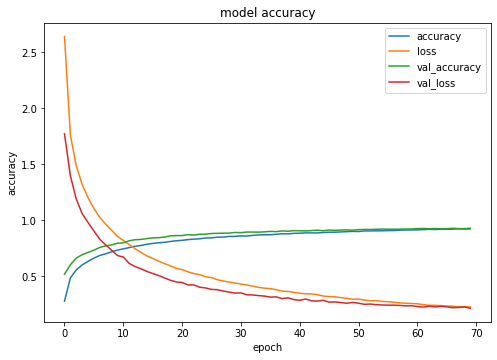

In [ ]:
train_acc=tran.history[0]['acc']
train_loss=tran.history[0]['loss']
val_acc=tran.history[0]['val_acc']
val_loss=tran.history[0]['val_loss']

plt.plot(train_acc)
plt.plot(train_loss)
plt.plot(val_acc)
plt.plot(val_loss)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss','val_accuracy', 'val_loss'], loc='upper right')
plt.savefig('acc_2_june_v4.png')
plt.show()


In [ ]:
# spark.catalog.clearCache()

In [ ]:
# for (id, rdd) in sc._jsc.getPersistentRDDs().items():
#     rdd.unpersist(blocking=True)
#     print("Unpersisted {} rdd".format(id))

In [ ]:
# images_df.unpersist(blocking=True)
# single_df.unpersist(blocking=True)
# del images_df,single_df
# import gc
# gc.collect()

617